# Expected SBS1 hotspot propensity using methylation data from Fig 5G-5H

In [1]:
from collections import defaultdict
import json

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
np.random.seed(54354)
import pandas as pd
import seaborn as sns

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [3]:
data_dir = '../../../data/'

### Load data

- Observed hotspot propensity calculations using 100 samples and 100-300 mutations per sample for 1000 iterations.
- Expected SBS1 hotspot propensities for different genomic regions and cancer types
- Expected SBS1 hotspot propensities for different genomic regions and cancer types, which account for variation in CpG methylation in tissue-matched epigenomes

In [4]:
cancertypes = ['COADREAD', 'ESOPHA_STOMACH', 'NSCLC']

In [5]:
binsizes = ['1000kb', '500kb', '250kb', '100kb', '50kb', '25kb', '10kb']

In [6]:
# Color gradients
model_color = {}

# Models with no methylation data
gradient = sns.color_palette("YlOrRd", 8)
for binsize, color in list(zip(binsizes, gradient[1:])): 
    model_color[f'exp_{binsize}'] = color

# Models including methylation data
gradient_me = sns.color_palette("Blues", 8)
for binsize, color in list(zip(binsizes, gradient_me[1:])): 
    model_color[f'exp_me_{binsize}'] = color

In [7]:
colors_d = {
    'explained': gradient, 
    'explained_me': gradient_me, 
    'missing': ['#f6f5f4ff'] * 7
}

In [8]:
# Observed SBS1 hotspot propensity using 30000 mutations
propensity_f = f'{data_dir}/hotspot_propensity_1000iter_100samples_100-300muts.txt.gz'
propensity_df = pd.read_csv(propensity_f, sep='\t', header=0)
propensity_df = propensity_df.loc[(propensity_df['TOTAL_MUTS'] == 30000) & (propensity_df['SIGNATURE'] == 'SBS1')].copy()
propensity_df.head()

,ITER,N_SAMPLES,TOTAL_HOTSPOTS,TOTAL_HOTSPOTS_UNIQPOS,TOTAL_MUTS,CTYPE,SIGNATURE
251000,BLADDER_URI_iter_0_SBS1,100,33,33,30000,BLADDER_URI,SBS1
251001,BLADDER_URI_iter_1_SBS1,100,45,45,30000,BLADDER_URI,SBS1
251002,BLADDER_URI_iter_2_SBS1,100,34,34,30000,BLADDER_URI,SBS1
251003,BLADDER_URI_iter_3_SBS1,100,42,42,30000,BLADDER_URI,SBS1
251004,BLADDER_URI_iter_4_SBS1,100,33,33,30000,BLADDER_URI,SBS1


In [9]:
# Expected hotspot propensity using models with no methylation information
expected_f_dict = defaultdict(dict) 
for bin_size in binsizes: 
    for ctype in cancertypes: 
        expected_f_dict[bin_size][ctype] = f'{data_dir}/expected_hotspot_propensity/{bin_size}_{ctype}_SBS1_300_100.nodrivers.relat_pcount.json'

In [10]:
# Expected hotspot propensity using models including methylation data
expected_me_f = f'{data_dir}/expected_hotspot_propensity/expected_hotspot_rate_methylation.json'
with open(expected_me_f, 'rt') as fd: 
    models_me_d = json.load(fd)

### Compute observed SBS1 hotspot propensity

In [11]:
observed = dict()
observed_samples = dict()
for cancertype in cancertypes:  
    df = propensity_df.loc[propensity_df['CTYPE'] == cancertype].copy()
    median = np.percentile(df['TOTAL_HOTSPOTS_UNIQPOS'], 50)
    q1 = np.percentile(df['TOTAL_HOTSPOTS_UNIQPOS'], 25)
    q3 = np.percentile(df['TOTAL_HOTSPOTS_UNIQPOS'], 75)
    observed[cancertype] = (median, q1, q3)
    observed_samples[cancertype] = df['TOTAL_HOTSPOTS_UNIQPOS'].tolist()
observed

{'COADREAD': (38.0, 34.0, 42.0),
 'ESOPHA_STOMACH': (39.0, 35.0, 44.0),
 'NSCLC': (35.0, 31.0, 38.0)}

### Compute expected SBS1 hotspot propensity

In [12]:
expected = defaultdict(dict)
for bin_size in binsizes: 
    for ctype in cancertypes: 
        with open(expected_f_dict[bin_size][ctype], 'r') as fd: 
            h_per_bin = json.load(fd)
        h_total = sum(h_per_bin.values())
        expected[ctype][bin_size] = h_total

In [13]:
expected

defaultdict(dict,
            {'COADREAD': {'1000kb': 11.276672386181698,
              '500kb': 11.56421085236148,
              '250kb': 11.814439149792921,
              '100kb': 12.213909422496348,
              '50kb': 12.640215669597701,
              '25kb': 13.369541573800703,
              '10kb': 15.35777039030827},
             'ESOPHA_STOMACH': {'1000kb': 10.743813838106265,
              '500kb': 10.975479918218259,
              '250kb': 11.255592856602275,
              '100kb': 11.863439210127321,
              '50kb': 12.690579722540944,
              '25kb': 14.194244119885045,
              '10kb': 18.530260490047144},
             'NSCLC': {'1000kb': 10.501033558123245,
              '500kb': 10.716349122478578,
              '250kb': 11.032521242285934,
              '100kb': 11.826732976375228,
              '50kb': 13.028689996038997,
              '25kb': 15.385938543043455,
              '10kb': 22.269554439137774}})

### Compute expected SBS1 hotspot propensity with methylation-aware models

In [14]:
expected_me = defaultdict(dict)
for bin_size in binsizes: 
    for ctype in cancertypes: 
        h_per_bin = models_me_d[ctype][bin_size]
        h_total = sum(h_per_bin.values())
        expected_me[ctype][bin_size] = h_total
expected_me

defaultdict(dict,
            {'COADREAD': {'1000kb': 22.123810388291822,
              '500kb': 22.96748447377775,
              '250kb': 23.66094723783125,
              '100kb': 24.54427456776858,
              '50kb': 25.42915710159138,
              '25kb': 26.843236082504056,
              '10kb': 30.52196198656896},
             'ESOPHA_STOMACH': {'1000kb': 19.862152009077835,
              '500kb': 20.506398509799222,
              '250kb': 21.155713593310594,
              '100kb': 22.35038362424558,
              '50kb': 23.94398595707319,
              '25kb': 26.933785348315052,
              '10kb': 35.641279253334766},
             'NSCLC': {'1000kb': 19.466353829925033,
              '500kb': 20.185930196664987,
              '250kb': 21.06718431559001,
              '100kb': 23.039330961086666,
              '50kb': 25.929835795453204,
              '25kb': 31.620801913410183,
              '10kb': 48.20245305540391}})

### Compute % explained by models (methylation unaware) for Fig 5H

In [15]:
sig = 'SBS1'
lines = []
header = ['CTYPE', 'H_OBS']
for i, binsize in enumerate(['1000kb', '500kb', '250kb', '100kb', '50kb', '25kb', '10kb']):
    header += [f'MEGA_{binsize}', f'MEGA_{binsize}_F', f'MEGA_{binsize}_GAIN']
header.append('MISSING')
    
for ctype in cancertypes: 
    
    subline = [ctype]
        
    # Observed
    observed_sig = observed[ctype][0]
    subline.append(observed_sig)
    
    # 1 Mbp model
    exp_mbp_sig = expected[ctype]['1000kb']
    f_exp_mbp_sig = 100 * exp_mbp_sig / observed_sig
    subline += [exp_mbp_sig, f_exp_mbp_sig, f_exp_mbp_sig]
        
    # Megabase and submegabase models
    pre_model = f_exp_mbp_sig
    for i, binsize in enumerate(['500kb', '250kb', '100kb', '50kb', '25kb', '10kb']):
               
        exp_submega_sig = expected[ctype][binsize]
        f_exp_submega_sig = 100 * exp_submega_sig / observed_sig
        
        # Gain 
        gain = f_exp_submega_sig - pre_model
        gain = 0 if gain < 0 else gain
        pre_model = f_exp_submega_sig
        
        subline += [exp_submega_sig, f_exp_submega_sig, gain]
    
    # Missing
    miss = 100 - f_exp_submega_sig
    subline.append(miss)
    
    lines.append(pd.DataFrame([subline]))
    
df_expected = pd.concat(lines)
df_expected.columns = header
df_expected

,CTYPE,H_OBS,MEGA_1000kb,MEGA_1000kb_F,MEGA_1000kb_GAIN,MEGA_500kb,MEGA_500kb_F,MEGA_500kb_GAIN,MEGA_250kb,MEGA_250kb_F,...,MEGA_50kb,MEGA_50kb_F,MEGA_50kb_GAIN,MEGA_25kb,MEGA_25kb_F,MEGA_25kb_GAIN,MEGA_10kb,MEGA_10kb_F,MEGA_10kb_GAIN,MISSING
0,COADREAD,38.0,11.276672,29.675454,29.675454,11.564211,30.432134,0.756680,11.814439,31.090629,...,12.640216,33.263725,1.121859,13.369542,35.183004,1.919279,15.357770,40.415185,5.232181,59.584815
0,ESOPHA_STOMACH,39.0,10.743814,27.548241,27.548241,10.975480,28.142256,0.594016,11.255593,28.860495,...,12.690580,32.539948,2.120873,14.194244,36.395498,3.855550,18.530260,47.513488,11.117991,52.486512
0,NSCLC,35.0,10.501034,30.002953,30.002953,10.716349,30.618140,0.615187,11.032521,31.521489,...,13.028690,37.224829,3.434163,15.385939,43.959824,6.734996,22.269554,63.627298,19.667474,36.372702


### Compute % explained by methylation-informed models for Fig 5H

In [16]:
sig = 'SBS1'
lines = []
header = ['CTYPE', 'H_OBS']
for i, binsize in enumerate(['1000kb', '500kb', '250kb', '100kb', '50kb', '25kb', '10kb']):
    header += [f'MEGA_{binsize}', f'MEGA_{binsize}_F', f'MEGA_{binsize}_GAIN']
header.append('MISSING')
    
for ctype in cancertypes: 
    
    subline = [ctype]
        
    # Observed
    observed_sig = observed[ctype][0]
    subline.append(observed_sig)
    
    # 1 Mbp model
    exp_mbp_sig = expected_me[ctype]['1000kb']
    f_exp_mbp_sig = 100 * exp_mbp_sig / observed_sig
    subline += [exp_mbp_sig, f_exp_mbp_sig, f_exp_mbp_sig]
        
    # Megabase and submegabase models
    pre_model = f_exp_mbp_sig
    for i, binsize in enumerate(['500kb', '250kb', '100kb', '50kb', '25kb', '10kb']):
               
        exp_submega_sig = expected_me[ctype][binsize]
        f_exp_submega_sig = 100 * exp_submega_sig / observed_sig
        
        # Gain 
        gain = f_exp_submega_sig - pre_model
        gain = 0 if gain < 0 else gain
        pre_model = f_exp_submega_sig
        
        subline += [exp_submega_sig, f_exp_submega_sig, gain]
    
    # Missing
    miss = 100 - f_exp_submega_sig 
    miss = 0 if miss < 0 else miss
    subline.append(miss)
    
    lines.append(pd.DataFrame([subline]))
    
df_expected_me = pd.concat(lines)
df_expected_me.columns = header
df_expected_me

,CTYPE,H_OBS,MEGA_1000kb,MEGA_1000kb_F,MEGA_1000kb_GAIN,MEGA_500kb,MEGA_500kb_F,MEGA_500kb_GAIN,MEGA_250kb,MEGA_250kb_F,...,MEGA_50kb,MEGA_50kb_F,MEGA_50kb_GAIN,MEGA_25kb,MEGA_25kb_F,MEGA_25kb_GAIN,MEGA_10kb,MEGA_10kb_F,MEGA_10kb_GAIN,MISSING
0,COADREAD,38.0,22.123810,58.220554,58.220554,22.967484,60.440749,2.220195,23.660947,62.265651,...,25.429157,66.918834,2.328638,26.843236,70.640095,3.721260,30.521962,80.320953,9.680858,19.679047
0,ESOPHA_STOMACH,39.0,19.862152,50.928595,50.928595,20.506399,52.580509,1.651914,21.155714,54.245419,...,23.943986,61.394836,4.086160,26.933785,69.060988,7.666152,35.641279,91.387896,22.326907,8.612104
0,NSCLC,35.0,19.466354,55.618154,55.618154,20.185930,57.674086,2.055932,21.067184,60.191955,...,25.929836,74.085245,8.258585,31.620802,90.345148,16.259903,48.202453,137.721294,47.376146,0.000000


## Panel 5G

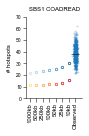

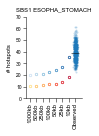

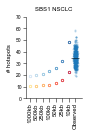

In [17]:
for ctype in cancertypes: 
    
    fig = plt.figure(figsize=(1.0, 1.5))
    ax = plt.subplot2grid((1, 1), (0, 0))
    ax.set_ylabel('# hotspots', fontsize=6)
    plt.title(f'SBS1 {ctype}', fontsize=6)

    sep = 0
    # Expected
    for i, binsize in enumerate(binsizes, 0):
        exp = expected[ctype][binsize]
        ax.scatter(i+sep, exp, color='white', marker='o', s=6, lw=0.75, edgecolor=model_color[f'exp_{binsize}'])
        exp = expected_me[ctype][binsize]
        ax.scatter(i+sep, exp, color='white', marker='o', s=6, lw=0.75, edgecolor=model_color[f'exp_me_{binsize}'])

    # Observed
    i += 1
    obs, o_error_min, o_error_max = observed[ctype]
    y_dispersion = list(np.random.normal(i-sep, (i-sep - 1)/50, size=1000))
    ax.scatter(y_dispersion, observed_samples[ctype], color='#1e79baff', alpha=0.25, marker='o', s=4, lw='0', zorder=1)
    ax.scatter(i-sep, obs, color='black', alpha=1, marker='_', s=50, lw=0.5, zorder=3)

    ax.set_xlim(-0.5, 8)
    ax.set_ylim(0, 70)
    ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70])
    ax.set_yticklabels([0, 10, 20, 30, 40, 50, 60, 70], fontsize=5)
    ax.tick_params(axis='y', which='both', pad=1)
    ax.tick_params(axis='x', which='both', pad=1)
    ax.set_xticks(list(range(len(binsizes) + 1)))
    ax.set_xticklabels(binsizes + ['Observed'], rotation=90, ha='center', va='top', fontsize=6)
    ax.spines['left'].set(lw=0.5)
    ax.spines['bottom'].set(lw=0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
    
    for extension in ['png']: 
        output = f'./fig_5G_{ctype}.{extension}'
        plt.savefig(output, bbox_inches='tight', dpi=350)

## Panel 5F

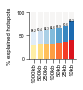

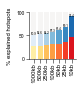

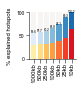

In [18]:
for ctype in cancertypes: 
    
    fig = plt.figure(figsize=(0.85, 0.85))
    ax = plt.subplot2grid((1, 1), (0, 0))
    ax.set_ylabel('% explained hotspots', fontsize=6)

    y_data = defaultdict(list)
    # Fraction explained per binsize
    for i, binsize in enumerate(binsizes):
        exp_nometh = df_expected.loc[df_expected['CTYPE'] == ctype][f'MEGA_{binsize}_F'].iloc[0]
        exp_meth = df_expected_me.loc[df_expected_me['CTYPE'] == ctype][f'MEGA_{binsize}_F'].iloc[0]
        y_data['explained'] += [exp_nometh]
        y_data['explained_me'] += [exp_meth - exp_nometh]
        missing = 100 - exp_meth
        missing = 0 if missing < 0 else missing
        y_data['missing'] += [missing]
        exp_meth = 100.0 if exp_meth > 100 else exp_meth
        ax.annotate(s=f'{round(exp_meth, 1)}', xy=(i, exp_meth+0.5), xytext=(i, exp_meth+0.5),fontsize=3, color='black', ha='center')

    bottom = None
    for model in ['explained', 'explained_me', 'missing']: 
        ax.bar(range(7), y_data[model], width=0.8, bottom=bottom, color=colors_d[model], align='center', alpha=1, lw=0)
        if not bottom: 
            bottom = y_data[model]
        else: 
            bottom = [bottom[i] + y_data[model][i] for i in range(len(bottom))] 

    ax.set_xlim(-0.75, 6.75)
    ax.set_ylim(0, 100)
    ax.set_yticks([0, 50, 100])
    ax.set_yticklabels([0, 50, 100], fontsize=5)
    ax.tick_params(axis='y', which='both', pad=1)
    ax.tick_params(axis='x', which='both', pad=1)
    ax.set_xticks(list(range(len(binsizes))))
    ax.set_xticklabels(binsizes, rotation=90, ha='center', fontsize=6)
    ax.spines['left'].set(lw=0.5)
    ax.spines['bottom'].set(lw=0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)

    for extension in ['png']: 
        output = f'./fig_5H_{ctype}.{extension}'
        plt.savefig(output, bbox_inches='tight', dpi=350)